# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [29]:
training_list = []
test_list = []
validation_list = []

name_to_label = {
            'Professorenbuero': 0,
            'Flur': 1,
            'Labor': 2,
            'Teekueche': 3
        }

for path_name in name_to_label.keys():
    pic_amount = 25
    tmp_paths = [(f"/content/drive/MyDrive/Colab Notebooks/Bilder/{path_name}/{path_name + str(i + 1)}.jpg", name_to_label[path_name] )for i in range(pic_amount)] #(Tensor,lbl) list
    random.shuffle(tmp_paths)

    training_list += tmp_paths[:int(0.7 * pic_amount)]
    validation_list += tmp_paths[int(0.7 * pic_amount):int(0.8 * pic_amount)] # 3 pics each
    test_list += tmp_paths[int(0.8 * pic_amount):]

training_path_list, y_train = [tup[0] for tup in training_list], [tup[1] for tup in training_list]
test_path_list, y_test = [tup[0] for tup in test_list], [tup[1] for tup in test_list]
validation_path_list, y_val = [tup[0] for tup in validation_list], [tup[1] for tup in validation_list] # ["./pfad/zu/bildZ.png","./pfad/zu/bildY.png",...], [1,1,1,2,2,2,...]

## Teilaufgabe b): CNN definieren und implementieren

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # cite
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(10816, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, x):
        """
        #layer 1
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        #layer 2
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        # layer 3
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        # layer 4
        x = self.dropout(self.pool(F.relu(self.conv4(x))))
        # flatten
        x = torch.flatten(x, 1)
        # dense layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        """
        #layer 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        #layer 2
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        # layer 3
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        # layer 4
        # x = self.pool(F.relu(self.conv4(x)))
        # flatten
        x = torch.flatten(x, 1)
        # dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden.

Input sind:
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!)
- Transformation der Bilder


In [31]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list

        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels

        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)

        # Label laden
        label = self.img_labels[idx]

        # Transformieren
        if self.transform:
            image = self.transform(image)

        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [32]:
from sklearn.metrics import accuracy_score


# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())

        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)

        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(),
                                       predicted.detach().cpu().numpy()))

    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

Running on  cuda:0

Started Training
Epoch 1 from 100
	Train Loss	 1.2506372
	Train Acc.	 0.4625
	Val Loss	 1.348548
	Val Acc.	 0.25
Epoch 2 from 100
	Train Loss	 0.42124423
	Train Acc.	 0.9
	Val Loss	 1.4681872
	Val Acc.	 0.25
Epoch 3 from 100
	Train Loss	 0.17681868
	Train Acc.	 0.975
	Val Loss	 1.8404993
	Val Acc.	 0.4166666666666667
Epoch 4 from 100
	Train Loss	 0.0648336
	Train Acc.	 0.975
	Val Loss	 2.147648
	Val Acc.	 0.4166666666666667
Epoch 5 from 100
	Train Loss	 0.043817
	Train Acc.	 0.9875
	Val Loss	 2.1320908
	Val Acc.	 0.5
Epoch 6 from 100
	Train Loss	 0.02496456
	Train Acc.	 1.0
	Val Loss	 1.9927659
	Val Acc.	 0.5
Epoch 7 from 100
	Train Loss	 0.007143275
	Train Acc.	 1.0
	Val Loss	 1.7141294
	Val Acc.	 0.5833333333333334
Epoch 8 from 100
	Train Loss	 0.0038696732
	Train Acc.	 1.0
	Val Loss	 1.3969036
	Val Acc.	 0.5
Epoch 9 from 100
	Train Loss	 0.00514635
	Train Acc.	 1.0
	Val Loss	 1.1824033
	Val Acc.	 0.5
Epoch 10 from 100
	Train Loss	 0.0019373072
	Train Acc.	 1.0
	V

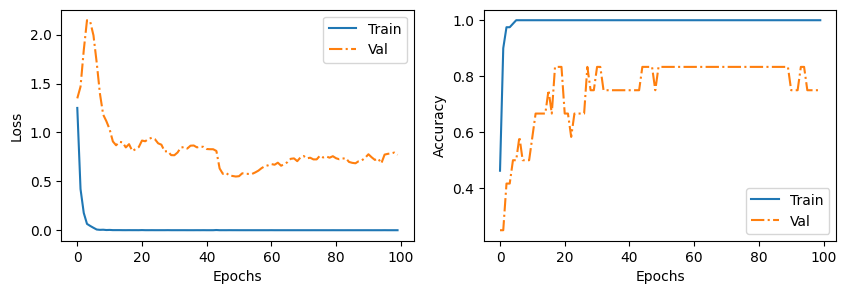

In [33]:
# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")

    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)

    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()

## Teilaufgabe d): Augmentierung

## Teilaufgabe e): Early Stopping